## Define the initial parameters for the function
**Graph Structure:** Includes the population size and graph shape

**Simulation Parameters:** Includes the timesteps and which world you want the simulation to be in (is the new hypothesis "true" or not). Use "new" or "old" to define which hypothesis is the true one.

In [1]:
# Define graph structure parameters
population = 10
graphShape = "wheel" # can be "cycle", "complete", or "wheel"

# Define simulation parameters
timesteps = 100
world = 'new' # can be "new" or "old"


## Define timestep function
This function will be run for every timestep, taking in the graph data structure as an argument.

In [2]:
from helpers import calculate_posterior
from typing import Literal
import networkx as nx
import random

# Define how to run an experiment
# Question, is this being done correctly?
def run_experiment(worldState: Literal['new', 'old']):
    return random.uniform(0.3, 0.8) if worldState == 'new' else random.uniform(0.2, 0.7)

def timestep(graph: nx.Graph):
    # Get node data
    nodes = graph.nodes(data=True)
    for node, data in nodes:
        # run a new experiment if the scientist has a greater than 50% belief that the hypothesis is true
        data['pEH'] = run_experiment(worldState=world) if data['beliefProb'] > 0.5 else None
        data['beliefProb'] = calculate_posterior(data['beliefProb'], data['pEH']) if data['pEH'] is not None else data['beliefProb']

    # update the scientists belief probability based on the observed evidence from their neighbors
    for node, data in nodes:
        neighbors = graph.neighbors(node)
        for neighbor in neighbors:
            neighbor_data = graph.nodes[neighbor]
            if neighbor_data['pEH'] is not None:
                data['beliefProb'] = calculate_posterior(data['beliefProb'], neighbor_data['pEH'])
        data['group'] = sum(data['beliefProb'] > x for x in [0, 0.4, 0.6, 1])
    return graph

## Initialize the graph
Initialize the graph with the defined shape set by the `graphShape` and `population` variables

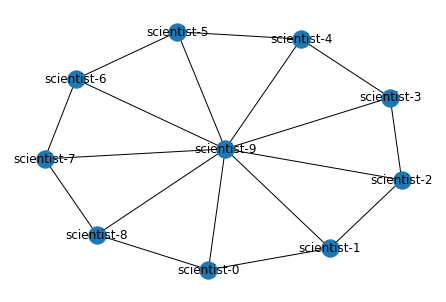

In [3]:
from helpers import initialize_graph

graph = initialize_graph(graphType=graphShape, numNodes=population)
nx.draw(graph, with_labels=True)

## Run the simulation
Run the simulation using the intialized graph, the `timestep` function defined above and the `timesteps` variable

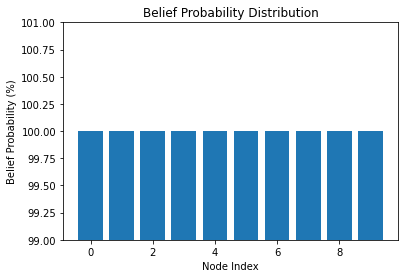

In [4]:
from helpers import run_simulation

results = run_simulation(graph=graph, timestep_func=timestep, num_timesteps=timesteps)
results.plot()